In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from scipy.optimize import fsolve
from scipy.stats import norm, ttest_1samp
import math

# Problem1

Assume you a call and a put option with the following

    ● Current Stock Price $165   
    ● Current Date 03/03/2023 
    ● Options Expiration Date 03/17/2023 
    ● Risk Free Rate of 4.25% 
    ● Continuously Compounding Coupon of 0.53% 
    
Calculate the time to maturity using calendar days (not trading days). 

For a range of implied volatilities between 10% and 80%, plot the value of the call and the put. 

Discuss these graphs. How does the supply and demand affect the implied volatility?

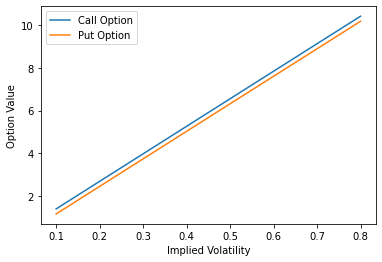

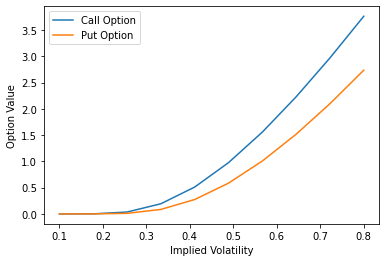

In [3]:
S = 165.0 # Current stock price
K = 165.0 # Strike price
r = 0.0425 # Risk-free rate
q = 0.0053 # Continuously compounding coupon rate
today = datetime(2023, 3, 3) # Today's date
expiration = datetime(2023, 3, 17) # Option expiration date

days_to_expiry = (expiration - today).days

iv = np.linspace(0.1, 0.8, 10)

def black_scholes_call(S, K, r, q, sigma, T):
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Nd1 = 0.5*(1 + np.math.erf(d1/np.sqrt(2)))
    Nd2 = 0.5*(1 + np.math.erf(d2/np.sqrt(2)))
    return S*np.exp(-q*T)*Nd1 - K*np.exp(-r*T)*Nd2

def black_scholes_put(S, K, r, q, sigma, T):
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Nd1 = 0.5*(1 + np.math.erf(-d1/np.sqrt(2)))
    Nd2 = 0.5*(1 + np.math.erf(-d2/np.sqrt(2)))
    return K*np.exp(-r*T)*Nd2 - S*np.exp(-q*T)*Nd1

call_values = [black_scholes_call(S, K, r, q, sigma, days_to_expiry/365) for sigma in iv]
put_values = [black_scholes_put(S, K, r, q, sigma, days_to_expiry/365) for sigma in iv]

plt.plot(iv, call_values, label='Call Option')
plt.plot(iv, put_values, label='Put Option')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.legend()
plt.show()

call_values = [black_scholes_call(S, K+20, r, q, sigma, days_to_expiry/365) for sigma in iv]
put_values = [black_scholes_put(S, K-20, r, q, sigma, days_to_expiry/365) for sigma in iv]

plt.plot(iv, call_values, label='Call Option')
plt.plot(iv, put_values, label='Put Option')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.legend()
plt.show()

# Problem2

Use the options found in AAPL_Options.csv 

    ● Current AAPL price is 151.03 
    ● Current Date, Risk Free Rate and Dividend Rate are the same as problem #1. 

Calculate the implied volatility for each option. Plot the implied volatility vs the strike price for Puts and Calls.

Discuss the shape of these graphs. What market dynamics could make these graphs?

In [4]:
df=pd.read_csv('AAPL_Options.csv')
df

,Stock,Expiration,Type,Strike,Last Price
0,AAPL,4/21/2023,Call,125,27.300
1,AAPL,4/21/2023,Call,130,22.575
2,AAPL,4/21/2023,Call,135,17.750
3,AAPL,4/21/2023,Call,140,13.850
4,AAPL,4/21/2023,Call,145,9.975
5,AAPL,4/21/2023,Call,150,6.700
6,AAPL,4/21/2023,Call,155,4.050
7,AAPL,4/21/2023,Call,160,2.210
8,AAPL,4/21/2023,Call,165,1.035
9,AAPL,4/21/2023,Call,170,0.460


In [5]:
S = 151.03 # Current stock price
X = df['Strike'].values # strike price
r = 0.0425 # Risk-free rate
q = 0.0053 # Continuously compounding coupon rate
p = df['Last Price'].values # prices
b = r-q
today = datetime(2023, 3, 3) # Today's date
expiration=datetime(2023, 4, 21) # expiration date
days_to_expiry = (expiration - today).days
ex=df['Type'].values

In [6]:
def gbsm(ex, underlying, strike, ttm, rf, b, ivol):
    d1 = (np.log(underlying/strike) + (b+ivol**2/2)*ttm)/(ivol*np.sqrt(ttm))
    d2 = d1 - ivol*np.sqrt(ttm)

    if ex=='Call':
        return underlying * np.exp((b-rf)*ttm) * norm.cdf(d1) - strike*np.exp(-rf*ttm)*norm.cdf(d2)
    else:
        return strike*np.exp(-rf*ttm)*norm.cdf(-d2) - underlying*np.exp((b-rf)*ttm)*norm.cdf(-d1)

In [7]:
ivol_ls=[]
for i in range(df.shape[0]):
    f=lambda ivol:gbsm(ex[i], S, float(X[i]), days_to_expiry/365, r, b, ivol) - float(p[i])
    ivol_ls.append(float(fsolve(f, 0.5)))

df['ivol']=ivol_ls
df

,Stock,Expiration,Type,Strike,Last Price,ivol
0,AAPL,4/21/2023,Call,125,27.300,0.374597
1,AAPL,4/21/2023,Call,130,22.575,0.342351
2,AAPL,4/21/2023,Call,135,17.750,0.292522
3,AAPL,4/21/2023,Call,140,13.850,0.299358
4,AAPL,4/21/2023,Call,145,9.975,0.278743
5,AAPL,4/21/2023,Call,150,6.700,0.263141
6,AAPL,4/21/2023,Call,155,4.050,0.246828
7,AAPL,4/21/2023,Call,160,2.210,0.235242
8,AAPL,4/21/2023,Call,165,1.035,0.223567
9,AAPL,4/21/2023,Call,170,0.460,0.219339


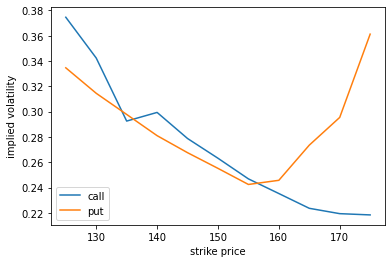

In [8]:
call_strike=df.iloc[:11, 3].tolist()
call_ivol=df.iloc[:11, -1].tolist()

put_strike=df.iloc[11:, 3].tolist()
put_ivol=df.iloc[11:, -1].tolist()

plt.plot(call_strike, call_ivol, label='call')
plt.plot(put_strike, put_ivol, label='put')
plt.xlabel('strike price')
plt.ylabel('implied volatility')
plt.legend()
plt.show()

# Problem3

Use the portfolios found in problem3.csv 

    ● Current AAPL price is 151.03 
    ● Current Date, Risk Free Rate and Dividend Rate are the same as problem #1. 

For each of the portfolios, graph the portfolio value over a range of underlying values. Plot the portfolio values and discuss the shapes. Bonus points available for tying these graphs to other topics discussed in the lecture. 

Using DailyPrices.csv. Calculate the log returns of AAPL. Demean the series so there is 0 mean. Fit an AR(1) model to AAPL returns. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean, VaR and ES. Discuss. 

Hints: 

    ● you will need to calculate the implied volatility - might not be the same as #2 
    ● you need to take into account the change in dates for option valuations. You are simulating forward in time and  options valuations are a function of time 
    ● Calculate the PL from the current portfolio value using Current Date

In [9]:
df=pd.read_csv('problem3.csv')
df

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,4/21/2023,150.0,6.80
1,Straddle,Option,AAPL,1,Put,4/21/2023,150.0,4.85
2,SynLong,Option,AAPL,1,Call,4/21/2023,150.0,6.80
3,SynLong,Option,AAPL,-1,Put,4/21/2023,150.0,4.85
4,CallSpread,Option,AAPL,1,Call,4/21/2023,150.0,6.80
5,CallSpread,Option,AAPL,-1,Call,4/21/2023,160.0,2.21
6,PutSpread,Option,AAPL,1,Put,4/21/2023,150.0,4.85
7,PutSpread,Option,AAPL,-1,Put,4/21/2023,140.0,1.84
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,151.03
9,Call,Option,AAPL,1,Call,4/21/2023,150.0,6.80


In [10]:
port=df['Portfolio'].tolist()
Type=df['Type'].tolist()
Holding=df['Holding'].tolist()
option=df['OptionType'].tolist()
X=df['Strike'].tolist()
exp_date=df['ExpirationDate'].tolist()
S=[50, 100, 150, 200, 250]
r = 0.0425 # Risk-free rate
q = 0.0053
b = r-q
current=df['CurrentPrice'].tolist()
underlying = 151.03

In [11]:
ttm=[]
for m in exp_date:
    if type(m) == str:
        m_split=m.split('/')
        delta=datetime(int(m_split[2]), int(m_split[0]), int(m_split[1]))-datetime(2023, 3, 3)
        ttm.append(delta.days/365)
    else:
        ttm.append(0)

In [12]:
#def gbsm(ex, underlying, strike, ttm, rf, b, ivol):
def portfolio_value(port, Type, Holding, option, S, X, ivol, ttm, rf, b):
    values=[]
    for i in range(len(port)):
        if Type[i]=='Stock':
            ind_value=S
        else:
            ind_value=gbsm(option[i], S, float(X[i]), ttm[i], rf, b, ivol[i])
        values.append(ind_value*Holding[i])
    
    return values
            

In [13]:
ivol_ls=[]
for i in range(len(port)):
    
    f=lambda ivol:gbsm(option[i], 151.03, float(X[i]), ttm[i], r, b, ivol) - float(current[i])
    ivol_ls.append(float(fsolve(f, 0.5)))

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


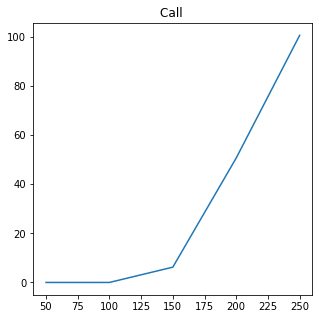

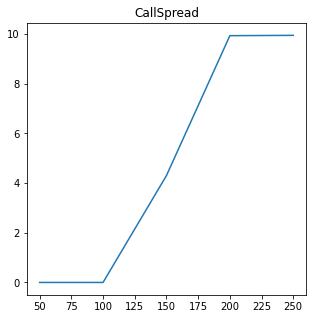

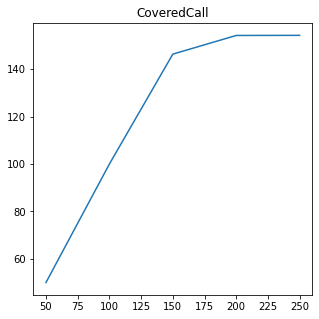

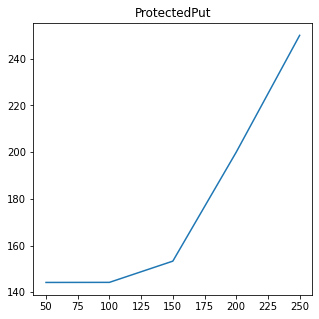

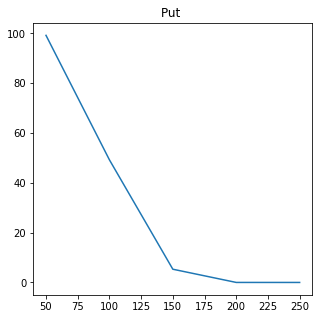

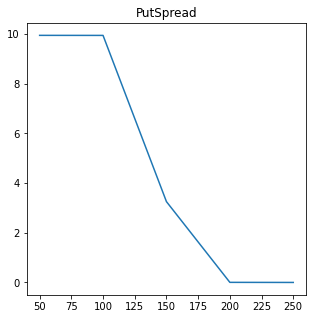

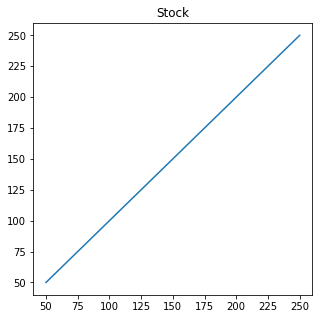

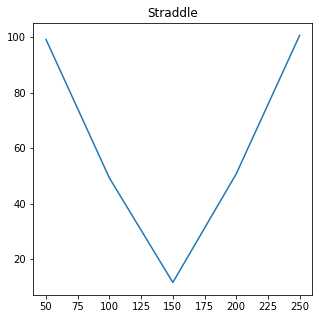

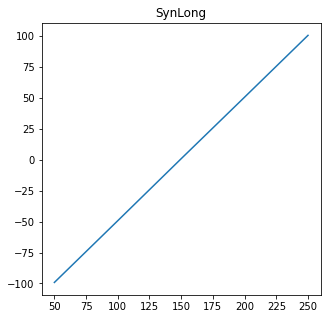

In [14]:
values_ls=[]
for i in range(len(S)):
    values=portfolio_value(port, Type, Holding, option, S[i], X, ivol_ls, ttm, r, b)
    port_value=pd.DataFrame(values, index=port)
    grouped_value=port_value.groupby(port_value.index)[0].sum()
    values_ls.append(pd.DataFrame(grouped_value))

for i in range(1, len(values_ls)):
    (values_ls[0])[i]=(values_ls[i])[0]

d=values_ls[0]
for m in d.index.tolist():
    plt.figure(figsize=(5,5))
    plt.plot(S, d.loc[m])
    plt.title(m)
    plt.show()


In [20]:
daily_price=pd.read_csv('DailyPrices.csv')
daily_price

,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,2/14/2022 0:00,432.011322,167.863144,292.261475,155.167007,291.920013,135.526001,135.300003,217.699997,242.443298,...,197.263107,64.592575,46.290192,151.118790,58.443172,377.068665,247.324020,48.182598,60.352272,66.789505
1,2/15/2022 0:00,438.978333,171.749573,297.680664,156.510498,307.476654,136.608505,136.425507,221.000000,264.702484,...,199.789520,64.328896,46.502743,159.029022,58.653572,372.440185,255.490829,49.446892,62.076630,67.673614
2,2/16/2022 0:00,439.470337,171.511032,297.333191,158.100494,307.796661,137.738007,137.487503,216.539993,264.862305,...,201.139511,64.172638,46.770744,165.211960,59.198696,377.000458,256.349976,50.203476,61.990410,65.915215
3,2/17/2022 0:00,430.082642,167.863144,288.626679,154.652496,292.116669,132.539002,132.308502,207.710007,244.841064,...,194.109894,64.514450,47.473091,157.448944,58.615318,378.822571,248.439911,48.600708,59.921181,64.019295
4,2/18/2022 0:00,427.297852,166.292648,285.846893,152.601502,285.660004,130.403000,130.467499,206.160004,236.199127,...,193.984528,64.455841,47.815025,157.380234,58.385788,376.571686,245.042847,48.381695,59.700851,64.981995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2/3/2023 0:00,412.350006,154.264465,258.350006,103.389999,189.979996,104.779999,105.220001,186.529999,211.000000,...,165.389999,65.910004,46.910000,178.820007,84.500000,459.079987,283.140015,41.130001,49.561237,80.222557
245,2/6/2023 0:00,409.829987,151.498688,256.769989,102.180000,194.759995,102.900002,103.470001,186.059998,210.889999,...,163.000000,66.169998,46.959999,177.550003,86.360001,469.100006,271.480011,41.340000,49.076408,79.853935
246,2/7/2023 0:00,415.190002,154.414230,267.559998,102.110001,196.809998,107.639999,108.040001,191.619995,221.729996,...,162.940002,65.080002,46.560001,181.020004,86.050003,468.329987,272.450012,41.400002,49.501869,79.565002
247,2/8/2023 0:00,410.649994,151.688400,266.730011,100.050003,201.289993,99.370003,100.000000,183.429993,222.050003,...,161.559998,64.790001,46.500000,177.759995,85.669998,469.649994,268.220001,41.570000,48.739998,80.309998


In [25]:
aapl=daily_price['AAPL']
lreturn=np.diff(np.log(aapl))
aapl_return=pd.DataFrame(lreturn-lreturn.mean())

In [26]:
model=sm.tsa.ARIMA(aapl_return, order=(1, 0, 0))
result=model.fit()
summary=result.summary()
forecast=result.forecast(steps=10)
m = float(summary.tables[1].data[1][1])
a1 = float(summary.tables[1].data[2][1])
s = math.sqrt(float(summary.tables[1].data[3][1]))

sim = pd.DataFrame(0, index=range(10000), columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7", "Day 8", "Day 9", "Day 10"])
for i in range(len(sim.columns)):
    for j in range(len(sim)):
        if i == 0:
            sim.iloc[j,i] =  a1 * (aapl_return.iloc[-1]) + s * np.random.normal() + m
        else:
            sim.iloc[j,i] =  a1 * (sim.iloc[j,i-1]) + s * np.random.normal() + m

In [27]:
sim_p = pd.DataFrame(0, index=range(10000), columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7", "Day 8", "Day 9", "Day 10"])
for i in range(len(sim_p.columns)):
    if i == 0:
        sim_p.iloc[:,i] = np.exp(sim.iloc[:,i]) * underlying
    else:
        sim_p.iloc[:,i] = np.exp(sim.iloc[:,i]) * sim_p.iloc[:,i-1]
sim_10 = sim_p.iloc[:,-1]
sim_10

0       141.323818
1       157.710639
2       138.332502
3       156.494998
4       131.843533
           ...    
9995    168.262010
9996    144.951206
9997    141.813935
9998    145.181575
9999    161.988343
Name: Day 10, Length: 10000, dtype: float64

In [28]:
ttm=[]
for m in exp_date:
    if type(m) == str:
        m_split=m.split('/')
        delta=datetime(int(m_split[2]), int(m_split[0]), int(m_split[1]))-datetime(2023, 3, 3)
        ttm.append((delta.days+10)/365)
    else:
        ttm.append(0)

In [29]:
port_value_df=pd.DataFrame(0, index=port, columns=np.linspace(0, 10000, 1))

In [30]:
for i in range(len(sim_10.tolist())):
    values=portfolio_value(port, Type, Holding, option, sim_10[i], X, ivol_ls, ttm, r, b)
    port_value=pd.DataFrame(values, index=port)
    port_value_df[i]=port_value

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  port_value_df[i]=port_value
<ipython-input-30-14bc21b22d7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  po

In [31]:
port_value_df

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,9990.0,9991.0,9992.0,9993.0,9994.0,9995.0,9996.0,9997.0,9998.0,9999.0
Straddle,3.097164,11.754154,2.218682,10.897650,0.949422,2.800854,10.251903,3.725707,11.277939,2.733226,...,6.326249,3.933857,4.172946,28.220880,10.222602,20.260267,4.447739,3.260934,4.544492,14.991918
Straddle,10.703746,2.980875,12.834402,3.333399,18.100205,11.346413,3.629707,9.527414,3.171530,11.502681,...,6.266458,9.183400,8.811602,0.358873,3.643836,1.009482,8.411942,10.374896,8.277672,1.968693
SynLong,3.097164,11.754154,2.218682,10.897650,0.949422,2.800854,10.251903,3.725707,11.277939,2.733226,...,6.326249,3.933857,4.172946,28.220880,10.222602,20.260267,4.447739,3.260934,4.544492,14.991918
SynLong,-10.703746,-2.980875,-12.834402,-3.333399,-18.100205,-11.346413,-3.629707,-9.527414,-3.171530,-11.502681,...,-6.266458,-9.183400,-8.811602,-0.358873,-3.643836,-1.009482,-8.411942,-10.374896,-8.277672,-1.968693
CallSpread,3.097164,11.754154,2.218682,10.897650,0.949422,2.800854,10.251903,3.725707,11.277939,2.733226,...,6.326249,3.933857,4.172946,28.220880,10.222602,20.260267,4.447739,3.260934,4.544492,14.991918
CallSpread,-0.717977,-5.327413,-0.434449,-4.759968,-0.121496,-0.617034,-4.345412,-0.948539,-5.009498,-0.594729,...,-2.106321,-1.029546,-1.125313,-18.903994,-4.326882,-11.836526,-1.238864,-0.775951,-1.279709,-7.635113
PutSpread,10.703746,2.980875,12.834402,3.333399,18.100205,11.346413,3.629707,9.527414,3.171530,11.502681,...,6.266458,9.183400,8.811602,0.358873,3.643836,1.009482,8.411942,10.374896,8.277672,1.968693
PutSpread,-5.289981,-1.129091,-6.667072,-1.286143,-10.437158,-5.695849,-1.421035,-4.568960,-1.213557,-5.795793,...,-2.726035,-4.363555,-4.144390,-0.106612,-1.427531,-0.330515,-3.912116,-5.085542,-3.834860,-0.700594
Stock,141.323818,157.710639,138.332502,156.494998,131.843533,140.389964,155.548307,143.120212,157.040034,140.167354,...,148.969498,143.670182,144.278875,176.930002,155.504676,168.262010,144.951206,141.813935,145.181575,161.988343
Call,3.097164,11.754154,2.218682,10.897650,0.949422,2.800854,10.251903,3.725707,11.277939,2.733226,...,6.326249,3.933857,4.172946,28.220880,10.222602,20.260267,4.447739,3.260934,4.544492,14.991918


In [32]:
grouped_value=port_value_df.groupby(port_value_df.index).sum()
grouped_value

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,9990.0,9991.0,9992.0,9993.0,9994.0,9995.0,9996.0,9997.0,9998.0,9999.0
Call,3.097164,11.754154,2.218682,10.897650,0.949422,2.800854,10.251903,3.725707,11.277939,2.733226,...,6.326249,3.933857,4.172946,28.220880,10.222602,20.260267,4.447739,3.260934,4.544492,14.991918
CallSpread,2.379186,6.426741,1.784234,6.137683,0.827926,2.183820,5.906490,2.777169,6.268441,2.138496,...,4.219929,2.904312,3.047633,9.316886,5.895720,8.423741,3.208875,2.484984,3.264783,7.356805
CoveredCall,139.773649,149.558690,137.311841,149.068318,131.491407,139.023239,148.660778,141.166686,149.292712,138.841840,...,145.185630,141.579186,142.027768,153.482689,148.641446,152.444881,142.513301,140.160462,142.677222,151.005168
ProtectedPut,148.944235,159.532543,147.716558,158.555368,145.812098,148.536147,157.811631,149.792989,158.990492,148.442208,...,153.125643,150.069570,150.384775,177.116467,157.777733,168.824019,150.743968,149.167484,150.869691,163.145758
Put,10.703746,2.980875,12.834402,3.333399,18.100205,11.346413,3.629707,9.527414,3.171530,11.502681,...,6.266458,9.183400,8.811602,0.358873,3.643836,1.009482,8.411942,10.374896,8.277672,1.968693
PutSpread,5.413764,1.851784,6.167330,2.047256,7.663047,5.650563,2.208672,4.958454,1.957973,5.706888,...,3.540423,4.819844,4.667212,0.252261,2.216305,0.678967,4.499826,5.289354,4.442812,1.268100
Stock,141.323818,157.710639,138.332502,156.494998,131.843533,140.389964,155.548307,143.120212,157.040034,140.167354,...,148.969498,143.670182,144.278875,176.930002,155.504676,168.262010,144.951206,141.813935,145.181575,161.988343
Straddle,13.800909,14.735029,15.053084,14.231049,19.049627,14.147266,13.881610,13.253122,14.449469,14.235907,...,12.592707,13.117257,12.984548,28.579753,13.866438,21.269749,12.859681,13.635830,12.822163,16.960611
SynLong,-7.606582,8.773280,-10.615719,7.564252,-17.150784,-8.545559,6.622196,-5.801707,8.106409,-8.769455,...,0.059791,-5.249542,-4.638656,27.862006,6.578766,19.250784,-3.964203,-7.113962,-3.733180,13.023225


In [33]:
def cal_ES(x,alpha=0.05):
    xs = np.sort(x)
    n = alpha * len(xs)
    iup = math.ceil(n)
    idn = math.floor(n)
    VaR = (xs[iup] + xs[idn]) / 2
    ES = xs[0:idn].mean()
    return VaR,ES

In [34]:
result=pd.DataFrame(0, index=grouped_value.index, columns=['Mean', 'VaR', 'ES'])

In [35]:
for i in range(len(grouped_value.index.tolist())):
    result.iloc[i, 0]=grouped_value.iloc[i, :].mean()
    result.iloc[i, 1], result.iloc[i, 2]=cal_ES(grouped_value.iloc[i, :])

In [36]:
result

,Mean,VaR,ES
Call,8.853603,1.480768,0.950756
CallSpread,4.806423,1.244200,0.822527
CoveredCall,145.338291,134.452168,131.003565
ProtectedPut,155.840830,146.634401,145.799971
Put,6.365668,0.907752,0.555817
PutSpread,3.345209,0.613972,0.382465
Stock,151.430180,135.066955,131.364529
Straddle,15.219271,12.591301,12.583657
SynLong,2.487936,-13.904047,-17.631984
